### CPSC 672 Network Project

In [30]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy import spatial
import csv
from tqdm.notebook import tqdm
import nbimporter
%run AdditionalClasses/NullCompare.ipynb import *
%run AdditionalClasses/GraphFromFile.ipynb import *
%matplotlib inline

### Data

The following few cells read in our data from a excel spreadsheet and organize them into a few arrays:
- stock_symbols contains all the actual stock names
- dates contains all the column headings (which are dates) from Feb 2010 to Dec 2021

In [129]:
df_total = pd.read_excel('data/all_data.xlsx', sheet_name='percentChange')
df_subset = pd.read_excel('data/subset_data.xlsx',sheet_name='percentChange')

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

In [65]:
stock_symbols = []
for stock in df_total['Stock']:
    stock_symbols.append(stock)

dates = df_total.columns.values
dates = dates[2:]

### Calculating links

To get the links between any two stocks, we use cosine similarity to determine how correlated two stocks are. The formula for cosine similarity is as follows:
$$ 
x = {1 - \frac{u \cdot v}{||u|| * ||v||}  }
$$
                            
the getSimilarities() functions do just that by comparing every stock, with every other stock, for any input date (column). Note one of the functions calculates this over a 12 month period (Yearly) whereas the other function uses the total dataset.

In [100]:
def getSimilaritiesTotal(dataFrame):
    similarities = []
    for i in tqdm(range(len(dataFrame))):
        for j in range(i+1,len(dataFrame)):
            first_stock = dataFrame.iloc[i,2:]
            second_stock = dataFrame.iloc[j,2:]
            result = 1 - spatial.distance.cosine(first_stock,second_stock)
            similarities.append((stock_symbols[i], stock_symbols[j], result))
    return similarities

In [101]:
def getSimilaritiesYearly(date,dataFrame):
    similarities = []
    elems = len(dataFrame[date])
    start_col = (np.where(dates == date)[0][0]) + 2 # plus 2 is for indexing away from stock symbol & sector
    end_col = start_col + 12
    for i in tqdm(range(elems)):
        for j in range(i+1,elems):
            first_stock = dataFrame.iloc[i,start_col:end_col]
            second_stock = dataFrame.iloc[j,start_col:end_col]
            result = 1-spatial.distance.cosine(first_stock,second_stock)
            similarities.append((stock_symbols[i], stock_symbols[j], result))
    return similarities

In [102]:
def getAllYears(dataFrame):
    i = 0
    arr = []
    start_date = dates[i]
    curr_year = start_date.year
    while(curr_year < 2021):
        yearly_similarity = getSimilaritiesYearly(start_date,dataFrame)
        arr.append((start_date,yearly_similarity))
        curr_year+=1
        i+=12
        start_date = dates[i]
    return arr

### Getting the total and Yearly similarities

In [38]:
total_similarities = getSimilaritiesTotal(df_total)

  0%|          | 0/2935 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [108]:
yearly_similarites = getAllYears(df_total)

  0%|          | 0/2935 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


  0%|          | 0/2935 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


  0%|          | 0/2935 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/2935 [00:00<?, ?it/s]

  0%|          | 0/2935 [00:00<?, ?it/s]

  0%|          | 0/2935 [00:00<?, ?it/s]

  0%|          | 0/2935 [00:00<?, ?it/s]

  0%|          | 0/2935 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


  0%|          | 0/2935 [00:00<?, ?it/s]

  0%|          | 0/2935 [00:00<?, ?it/s]

  0%|          | 0/2935 [00:00<?, ?it/s]

### Exporting
At this point all the stock symbols are exported to csv files, each year has it's own specific set of links. And there is also a csv that contains the total similarity across the entire dataset

In [104]:
def writeStocks():
    with open('data/stocks.csv','w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID	label"])
        for stock in stock_symbols:
            writer.writerow([str(stock_symbols.index(stock))+"\t"+stock])

In [105]:
def writeTotal(threshold):
    with open('data/links_total.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Source	Target	Weight"])
        for link in total_similarities:
            first_stock_index = str(stock_symbols.index(link[0]))
            second_stock_index = str(stock_symbols.index(link[1]))
            link_weight = link[2]
            if(abs(link_weight) > threshold):
                writer.writerow([first_stock_index+"\t"+second_stock_index+"\t"+str(link_weight)])

In [123]:
def writeYearly(yearly_calc,threshold):
    for year in yearly_calc:
        curr_year = year[0].year
        links = year[1]
        file_name = 'data/links_'+str(curr_year)+'.csv'
        with open(file_name, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Source	Target	Weight"])
            for link in links:
                first_stock_index = str(stock_symbols.index(link[0]))
                second_stock_index = str(stock_symbols.index(link[1]))
                link_weight = link[2]
                if(abs(link_weight) > threshold):
                    writer.writerow([first_stock_index+"\t"+second_stock_index+"\t"+str(link_weight)])

In [114]:
writeStocks()
writeTotal(0.5)

In [125]:
writeYearly(yearly_similarites,0.6)

### Visualizing the Data
Now that the data has been processed and exported into their own csv's , we can begin to do some visualiation and more graph theory related calculations.
Also, due to lack of computational resources, we have decided to reduce the number of links to 100,000 . The following two functions take the original csv's and take the strongest 100,000 links and save them. Links who do not make the cut are simply discarded.

In [5]:
def filterYearly(num_of_links):
    for i in range(2010,2021):
        df_link=pd.read_csv("data/links_"+str(i)+".csv",delimiter="\t")
        df_link = df_link.sort_values(by=['Weight'],key=abs,ascending=False,ignore_index=True)
        df_link[:num_of_links].to_csv("data/Filtered/links_"+str(i)+".csv",sep='\t',index=False)

In [6]:
def filterTotal(num_of_links):
        df_link=pd.read_csv("data/links_total.csv",delimiter="\t")
        df_link = df_link.sort_values(by=['Weight'],key=abs,ascending=False,ignore_index=True)
        df_link[:num_of_links].to_csv("data/Filtered/links_total.csv",sep="\t",index=False)

In [65]:
filterYearly(100000)
filterTotal(100000)


NameError: name 'filterYearly' is not defined

In [17]:
Yearly_Graphs = []
for i in range(2010,2021):
    G =GraphFromFile().GraphFromFileYearlyAbsWeights(i)
    Yearly_Graphs.append(G)

In [13]:
Total_Graph = []
Total_Graph.append(GraphFromFile().GraphFromFileTotalAbsWeights())


In [60]:
def PlotGraphDegDistribution(Graph_list):
    fig = plt.figure(figsize=(6,4))
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    for i in range(len(Graph_list)):
        G = Graph_list[i]
        N = len(G)
        L = G.size()
        degrees = [G.degree(node,weight='weight') for node in G]
        kmin = min(degrees)
        kmax = max(degrees)

        # Get 10 logarithmically spaced bins between kmin and kmax
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

        # histogram the data into these bins
        density, _ = np.histogram(degrees, bins=bin_edges, density=True)


        # "x" should be midpoint (IN LOG SPACE) of each bin
        log_be = np.log10(bin_edges)
        x = 10**((log_be[1:] + log_be[:-1])/2)
        label = 2010 +i if len(Graph_list) > 1 else "total"
        plt.loglog(x, density, marker='o', label = label,linestyle='none')


        # remove right and top boundaries because they're ugly
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        # Show the plot
    plt.legend()
    plt.show()


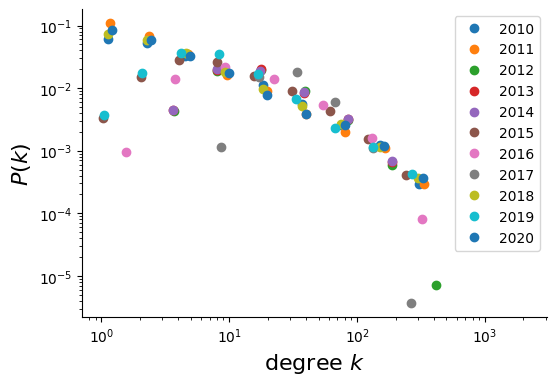

In [106]:
PlotGraphDegDistribution(Yearly_Graphs)           #for ploting total graph degree distribution
# PlotGraphDegDistribution(Total_Graph)               #for ploting total graph degree distribution

In [18]:
G = Total_Graph[0]
CG = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(CG[0])                 # select the biggest connected component

In [32]:
n = NullCompare(G)

In [25]:
C,d = n.CalculateStats()
print("Average Clustering Coefficient: ", C)
print("Average Shortest Path: ", d)

Average Clustering Coefficient:  0.6678847956398628
Average Shortest Path:  2.728443762372391


In [33]:
clustering_ER,short_path_ER = n.ERStats()
print(np.mean(clustering_ER))
print(np.std(clustering_ER))

print(np.mean(short_path_ER))
print(np.std(short_path_ER))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
0.06253337754540751
0.00026697821979401216
1.9382554482385224
0.0002736695510153474


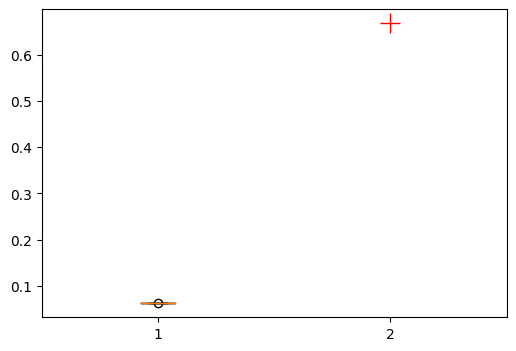

In [34]:
n.ClusteringCoffPlot(clustering_ER,C)


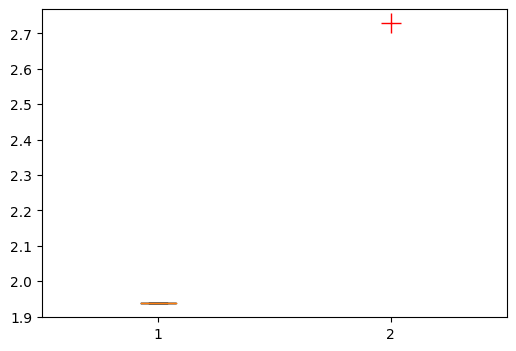

In [36]:
n.ShortPathPlot(short_path_ER,d)